# Welcome to syftr!

## What is syftr?
__syftr__ is an agent optimizer that helps you find the best agentic workflows for your budget. You bring your own dataset, compose the search space from models and components you have access to, and syftrer finds the best combination of parameters for your budget. 

## Getting started
In this notebook we will guide you through your very first steps with __syftr__. First, review the `README.md` for initial environment setup - here we assume that it is done. If the setup is correct, you should not have any problems running this example. We won't be composing any new search spaces yet and use an existing example study, but we will be giving any explanations along the way.

PLEASE NOTE that in order to function properly __syftr__ requires access to LLM APIs for inference and evaluation which aren't provided.

## Example study

__syftr__ study configuration file is a YAML file that contains all necesssary information to run study successfully.

It contains:
* _name_: it is used as a job ID in the cluster and can be referred later on to get optimization results.
* _dataset_: name, description, partitions spec, location. Used to describe the data location and data partitioning scheme.
* _evaluation_: configure the evaluator for your task, such as judge LLM(s) and evaluation metric.
* _optimization_: a section with technical parameters for optimization including number of trials, concurrency, batching of evaluation datasets etc.
* _search_space_: this is a specification of search space of a current study. Includes agent types, embedding models, splitters rerankers and so on.
* _toy_mode_: enables a variety of settings for rapid validation and debugging, such as limiting the grounding data and evaluation dataset sizes used.

If parameter value is not specified in a study config file, the default value from `syftr/studies.py` will be used..

In this particular tutorial we will take a look at our example study that specifies some non-RAG and RAG workflows over _DRDocs_ dataset (a collection DataRobot API docs). 
Our goal is to run a study and get some meaniningful results. 

The number of trials is set to 10 to get you started and validate that __syftr__ is operational. We will use CPU only embedding models, disable advanced features like HyDE, , query decomposition and reranking. Also, we will use OpenAI only models. 

Overall, this search space will allow us to quickly compare how RAG workflows compare with using just models on _DRDocs_ dataset.

In [7]:
!cat ../studies/example-dr-docs.yaml

dataset:
  xname: drdocs_hf
name: example-dr-docs
optimization:
  cpus_per_trial: 1
  embedding_device: cpu
  max_concurrent_trials: 4
  num_eval_batch: 5
  num_eval_samples: 10
  num_trials: 10
recreate_study: true
reuse_study: false
search_space:
  few_shot_enabled:
  - false
  hyde_enabled:
  - false
  rag_modes:
  - no_rag
  - rag
  rag_retriever:
    embedding_models:
    - BAAI/bge-small-en-v1.5
    - BAAI/bge-large-en-v1.5
    methods:
    - dense
    - sparse
    query_decomposition_enabled:
    - false
    top_k:
      kmax: 10
      kmin: 2
      log: false
      step: 1
  reranker_enabled:
  - false
  response_synthesizer_llms:
  - gpt-4o-mini
  - gpt-35-turbo
  - gpt-4o-std
  template_names:
  - default
  - concise
toy_mode: true


## Running your first study

__syftr__ has an easy-to-use Python API for interacting with the optimizer and analyzing results. In this section we will use the API to run the example study from the previous section. 

Let's create a study object from the file:

In [4]:
from syftr import api
from syftr.configuration import cfg

example_study = api.Study.from_file(cfg.paths.studies_dir / "example-dr-docs.yaml")
example_study

Study(name=example-dr-docs, remote=False)

We can see the name of study and that it is a local study, as `remote=False`. In this case __syftr__ will be run locally. 

A study object has `run()` method that can be used to start optimization. The method is non-blocking: it submits the current study to a Ray cluster and returns. If local mode is selected, a local Ray instance will be started automatically.



In [14]:
example_study.run()

[W 2025-05-07 16:25:05,838] Using existing ray client with address 'None'
[I 2025-05-07 16:25:06,221] Submitting job to local Ray instance
INFO:syftr:Submitting job to local Ray instance
2025-05-07 16:25:06,266	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_520985f7bbb82bdc.zip.
2025-05-07 16:25:06,266	INFO packaging.py:600 -- Creating a file package for local module '/Users/nick.volynets/workspace/syftr/ray_working_dir'.
2025-05-07 16:25:06,329	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_675ed93aa14255ae.zip.
2025-05-07 16:25:06,329	INFO packaging.py:600 -- Creating a file package for local module '/Users/nick.volynets/workspace/syftr/syftr'.
2025-05-07 16:25:06,631	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_93821878b6f7067f.zip.
2025-05-07 16:25:06,631	INFO packaging.py:600 -- Creating a file package for local module '/Users/nick.volynets/workspace/syftr/benchmarking'.


A study object has `wait_for_completion()` method that can be used to block execution until a study completes, but since we are in the Jupyter environment using it is not necessary.

In [ ]:
# await example_study.wait_for_completion()

After the study job successfully completes, we can inspect its results. A `Study` object has `plot_pareto` method that shows the Pareto front visualization of a study.

This plot highlights the best trade-offs between accuracy and cost. Each point represents a trial, and the gray ones are the ones that didn’t do as well compared to the ones on the Pareto front.

In this case, using RAG gives better results than not using it. Workflows that used RAG tend to be closer to the Pareto front, meaning they achieve a better balance between accuracy and cost.

GPT-3.5-turbo didn’t do as well as GPT-4-Mini, which lines up with what we’d expect, even if it comes with a higher cost.

Overall, the plot gives a nice overview of which workflows are actually worth considering and which ones just aren’t competitive.

Loading Studies: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.48it/s]

data has 11 rows

Running: create_study_stats_table
Running: create_exceptions_stats_table
Running: pareto_plot_and_table
data has 11 rows
Running: generate_trial_description_table
data has 3 rows
data has 11 rows
Running: style_pareto_table


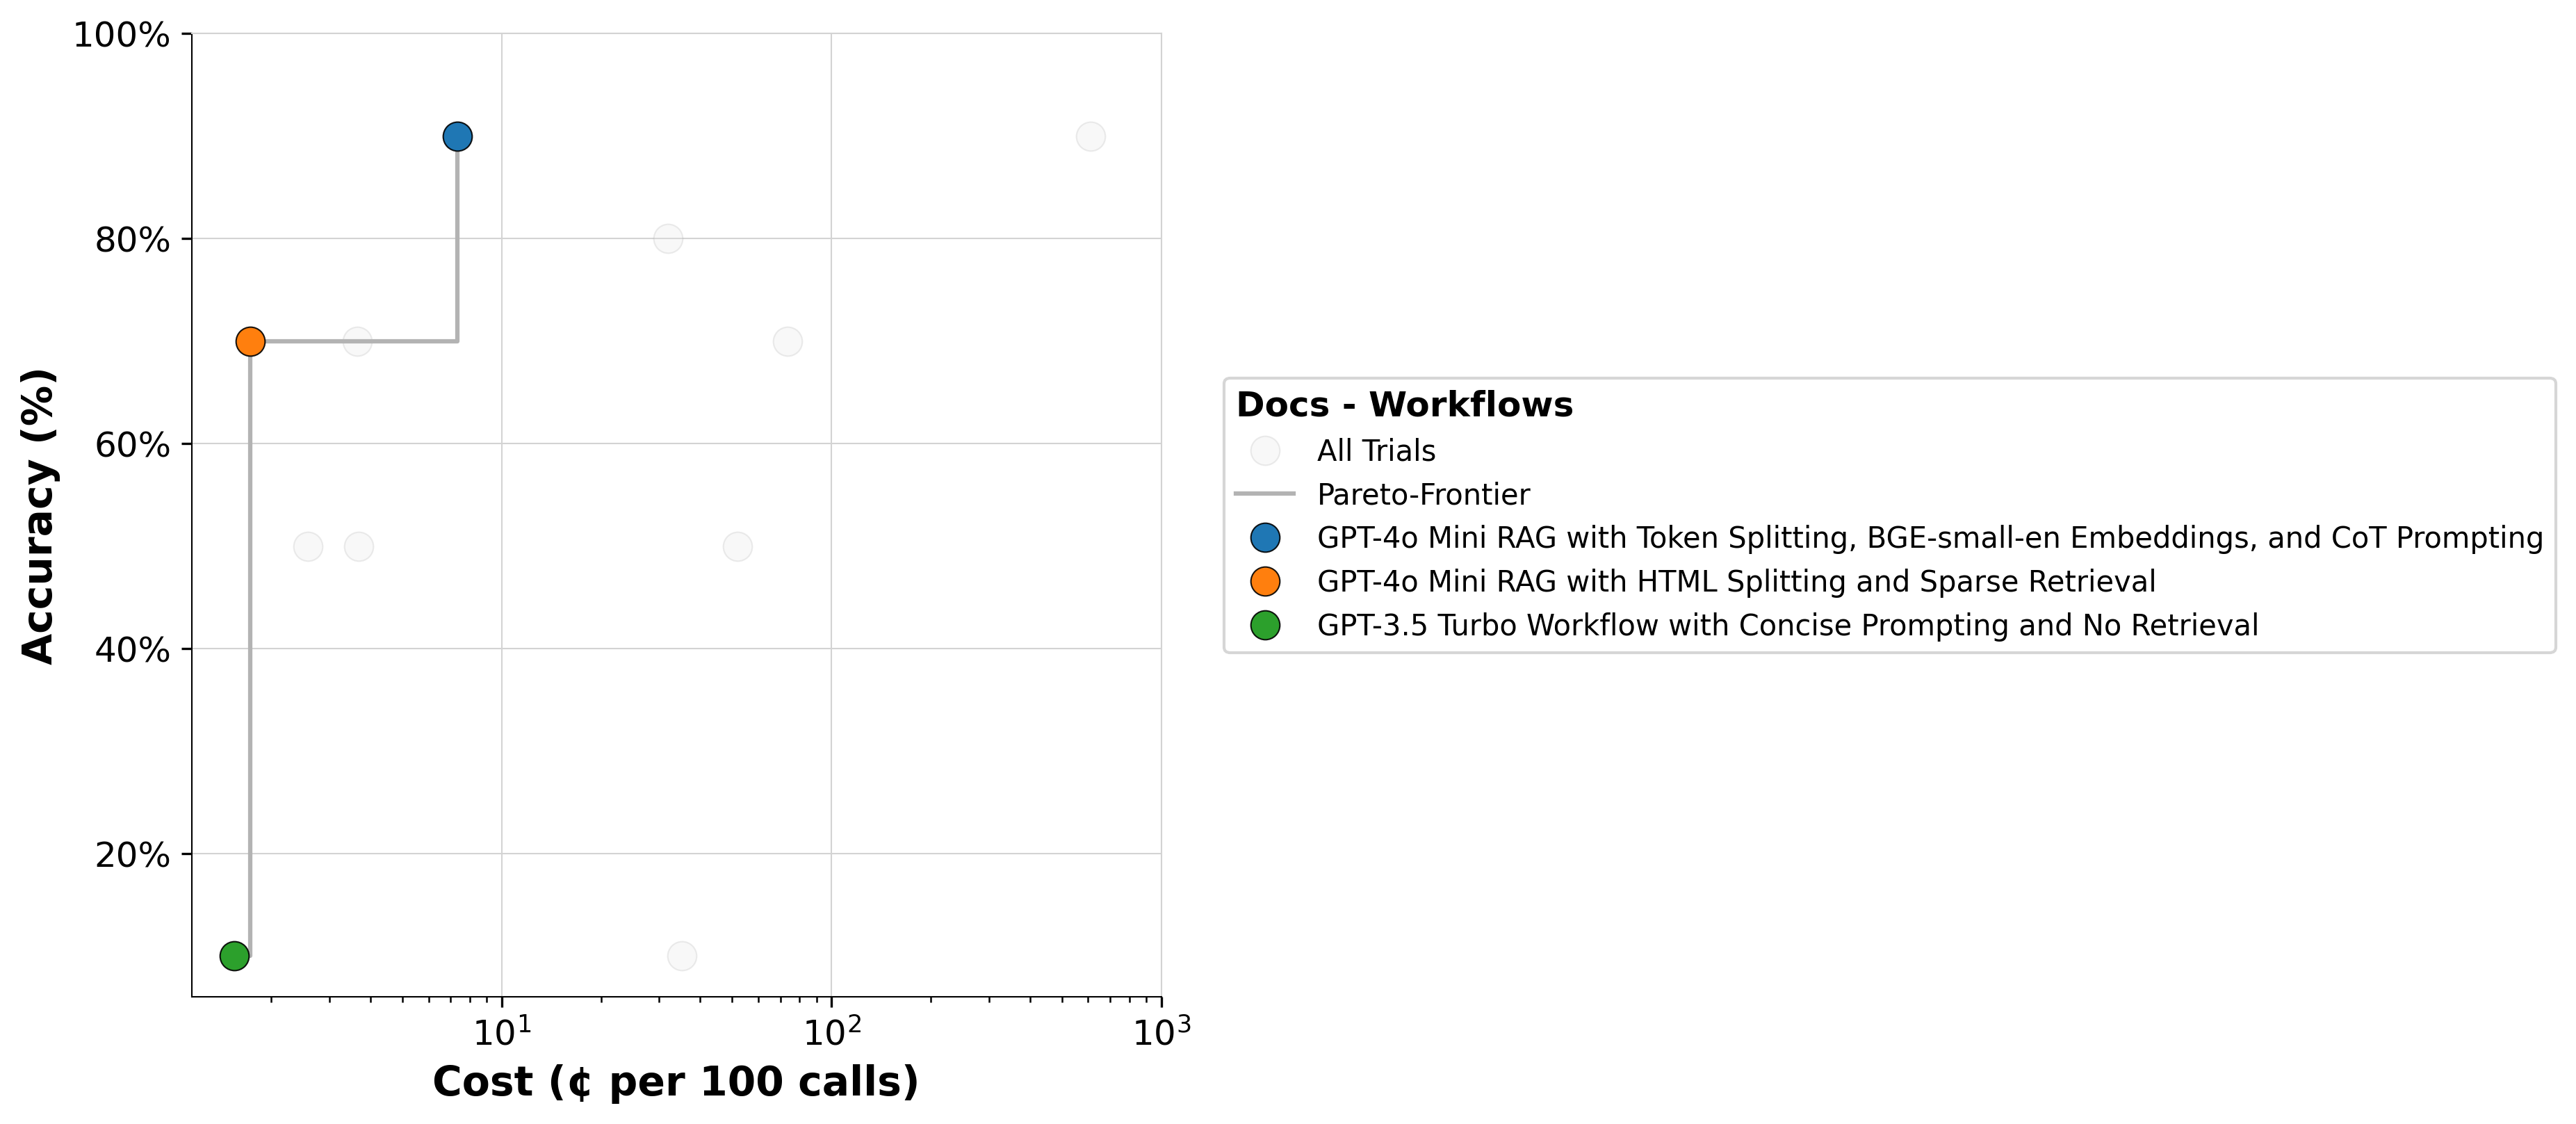

In [17]:
example_study.plot_pareto()

In addition to `plot_pareto`, `pareto_flows` attribute returns __the Pareto front__ of a study: a set of flows with optimal accuracy and cost. Each flow has `metrics` attribute with resulting accuracy and cost, as well as `params` which contains the flow components.

In [15]:
example_study.pareto_flows

[I 2025-05-07 16:57:24,378] Loaded 11 trials
INFO:syftr:Loaded 11 trials


[{'metrics': {'accuracy': 0.7, 'llm_cost_mean': 0.000258675},
  'params': {'response_synthesizer_llm': 'gpt-4o-mini',
   'rag_mode': 'no_rag',
   'template_name': 'default',
   'enforce_full_evaluation': True}},
 {'metrics': {'accuracy': 0.8, 'llm_cost_mean': 0.00395046},
  'params': {'rag_mode': 'rag',
   'template_name': 'concise',
   'response_synthesizer_llm': 'gpt-4o-mini',
   'few_shot_enabled': False,
   'reranker_enabled': False,
   'hyde_enabled': False,
   'additional_context_enabled': True,
   'rag_method': 'dense',
   'rag_query_decomposition_enabled': False,
   'rag_top_k': 10,
   'rag_embedding_model': 'BAAI/bge-small-en-v1.5',
   'splitter_method': 'recursive',
   'splitter_chunk_exp': 12,
   'splitter_chunk_size': 4096,
   'splitter_chunk_overlap_frac': 0.0,
   'additional_context_num_nodes': 13}},
 {'metrics': {'accuracy': 1.0, 'llm_cost_mean': 0.04073575},
  'params': {'rag_mode': 'rag',
   'template_name': 'default',
   'response_synthesizer_llm': 'gpt-4o-std',
   'f

In addition to `pareto_flows`, a successfully completed study has an attribute `knee_point` which returns a [knee](https://en.wikipedia.org/wiki/Knee_of_a_curve) of the __syftr__'s Pareto front

In [16]:
example_study.knee_point

[I 2025-05-07 16:57:41,877] Loaded 11 trials
INFO:syftr:Loaded 11 trials


{'metrics': {'accuracy': 0.8, 'llm_cost_mean': 0.00395046},
 'params': {'rag_mode': 'rag',
  'template_name': 'concise',
  'response_synthesizer_llm': 'gpt-4o-mini',
  'few_shot_enabled': False,
  'reranker_enabled': False,
  'hyde_enabled': False,
  'additional_context_enabled': True,
  'rag_method': 'dense',
  'rag_query_decomposition_enabled': False,
  'rag_top_k': 10,
  'rag_embedding_model': 'BAAI/bge-small-en-v1.5',
  'splitter_method': 'recursive',
  'splitter_chunk_exp': 12,
  'splitter_chunk_size': 4096,
  'splitter_chunk_overlap_frac': 0.0,
  'additional_context_num_nodes': 13}}